# Экстраполяция временных рядов

### Однопараметрическая экстраполяция

![Забавный комикс](https://imgs.xkcd.com/comics/extrapolating.png)


*Источник https://xkcd.com/605/*

**Экстраполяция** — это процесс прогнозирования значений за пределами диапазона имеющихся данных. Например, если у вас есть данные за последние несколько лет, вы можете экстраполировать, как будут выглядеть значения в будущем. Это предполагает, что существующие тенденции будут продолжаться.

**Задача регрессии** — это метод статистического анализа, который используется для предсказания значений зависимой переменной на основе одной или нескольких независимых переменных.
*В этой задаче модель обучается на имеющихся данных, чтобы выявить зависимости и закономерности.*
Основная цель регрессии заключается в том, чтобы установить зависимость между переменными и создать модель, которая может предсказывать значения зависимой переменной на основе новых данных. (Например, цены квартиры или телефона, курса доллара на завтра, ожидаемого объёма продаж, медицинских показателей до/после лечения и так далее)

Например, пусть X = ξ+η – это сумма случайных величин ξ и η, а Y = ξ + ϕ – сумма случайных величин ξ и ϕ. Ясно, что величины X и Y зависимы, но нет явной функциональной зависимости, то есть мы не можем указать зависимость вида X = f(Y) или Y = f(X).

Таким образом, основное различие в том, что регрессия используется для моделирования зависимости на основе имеющихся данных, а экстраполяция — для предсказания значений вне диапазона этих данных.

Когда вы строите регрессионную модель, вы выбираете функцию (например, линейную, полиномиальную или экспоненциальную), которая наилучшим образом описывает зависимость между переменными на основе имеющихся данных. Эта же функция может быть затем использована для экстраполяции, чтобы предсказать значения вне диапазона данных.

Однако важно помнить, что экстраполяция может быть менее надежной, поскольку предполагает, что выявленные закономерности сохранятся за пределами изученного диапазона. Поэтому при экстраполяции стоит быть осторожным и учитывать возможные изменения в трендах или условиях.

In [1]:
# импортируем основные бибилиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Загрузим данные. В практической работе можно использовать эти данные https://goo.su/PNlL или взять данные с открытых источников

DataSet1_3.csv - Стоимость и объем продаж акций компании Google

DataSet1_4.csv - статистика заболеваемости COVID-19 по странам

DataSet3_1.csv - данные о температуре и потребляемой мощности электрической энергии

DataSet3_2.csv - данные о стоимости доллара и нефти

In [2]:

# Стоимость и объем продаж акций компании Google (работа с временными рядами, может быть решена задача прогнозирования)
data1 = pd.read_csv('./DataSet1_3.csv')

In [3]:
# Посмотрим на содержание таблицы
data1.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
1,2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2,2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
3,2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
4,2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


На этом семинаре мы будем строить модели только по двум переменным $x$ и $y$.

In [4]:
# из всего объёма данных выберем 100-200 значений для прогноза (так удобнее для визуализации)
n1 = 101
n2 = 300
data = pd.DataFrame()

# в качестве переменной x будем использовать дни
data1['Date'] = pd.to_datetime(data1['Date'], format="%Y-%m-%d")
data['x'] = (data1['Date'] - data1['Date'].iloc[0]).dt.days.loc[n1:n2]
data['x'] -= data['x'].iloc[0] - 1
#переменная, которую мы будем прогнозировать
data['y'] = data1['Close'].loc[n1:n2]
data.reset_index(inplace=True, drop=True)
data

,x,y
0,1,186.16
1,2,186.10
2,3,191.50
3,4,189.91
4,7,187.41
...,...,...
195,284,226.71
196,287,227.60
197,288,221.74
198,289,224.22


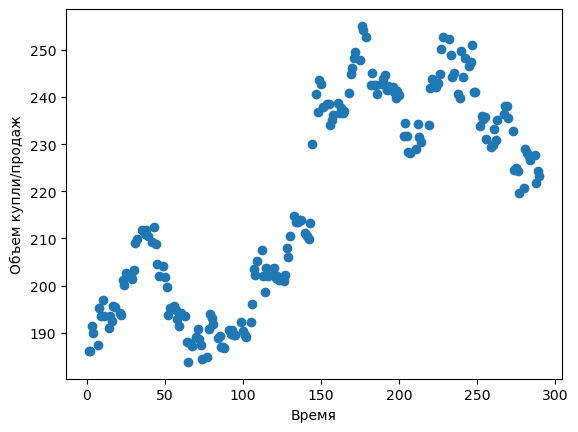

In [5]:
#посмотрим на данные
plt.scatter(data['x'], data['y'])
plt.xlabel('Время')
plt.ylabel('Объем купли/продаж')
plt.show()

### Метод наименьших квадратов

Одним из часто встречающихся на практике методе, используемый в самых различных его модификациях, является метод наименьших квадратов (МНК). Этот метод был опубликован в современном виде **более двухсот лет назад**!

Пусть у нас задан датасет $(X, y)$, где $y=(y_i)_{i=1}^N \in \mathbb{R}^N$ – вектор значений целевой переменной, а $X=(x_i)_{i = 1}^N \in \mathbb{R}^{N \times D}, x_i \in \mathbb{R}^D$ – матрица объекты-признаки, в которой
$i$-я строка – это вектор признаков $i$-го объекта выборки. Мы хотим моделировать зависимость $y_{i}$ от $x_{i}$ как линейную функцию со свободным членом. Общий вид такой функции из $\mathbb{R}^D$  в $\mathbb{R}$ выглядит следующим образом:

$\color{#348FEA}{f_w(x_i) = \langle w, x_i \rangle + w_0}$



**Сведение к задаче оптимизации**

Мы хотим, чтобы на нашем датасете (то есть на парах $(x_i, y_i)$ из обучающей выборки) функция $f_w$ как можно лучше приближала нашу зависимость.

![image.png](attachment:image.png)

(источник изображения https://academy.yandex.ru/handbook/ml/article/linear-models)

Говоря простым языком, мы должны научиться измерять качество модели и минимизировать её ошибку, как-то меняя обучаемые параметры. В нашем примере обучаемые параметры — это веса $w$.

Функция, оценивающая то, как часто модель ошибается, традиционно называется **функцией потерь, функционалом качества или просто лоссом (loss function)**.

Функции потерь бывают разными. От их выбора зависит то, насколько задачу в дальнейшем легко решать, и то, в каком смысле у нас получится приблизить предсказание модели к целевым значениям.

Интуитивно понятно, что для нашей текущей задачи нам нужно взять вектор $y$
и вектор предсказаний модели и как-то сравнить, насколько они похожи. Так как эти вектора «живут» в одном векторном пространстве, расстояние между ними вполне может быть функцией потерь.

При этом способов задать расстояние между векторами тоже довольно много. (См. лекции или Л.А.Мыльников "Статистические методы интеллектуального анализа данных").  Сейчас давайте в качестве лосса возьмём квадрат $L^2$-нормы вектора разницы предсказаний модели и $y$.

$L(f, X, y) = |y - f(X)|_2^2 = = \|y - Xw\|_2^2 = \sum_{i=1}^N(y_i - \langle x_i, w \rangle)^2$

Однако, такой функционал ошибки не очень хорош для сравнения поведения моделей на выборках разного размера. Представьте, что вы хотите понять, насколько качество модели на тестовой выборке из 2000 объектов хуже, чем на обучающей из 7000 объектов. Вы измерили $L^2$-норму ошибки и получили в одном случае 200, а в другом 500. Эти числа не очень интерпретируемы. Гораздо лучше посмотреть на среднеквадратичное отклонение. Такая функция ошибки называется **Mean Squared Error, MSE или среднеквадратическим отклонением.**

$\color{#348FEA}{\text{MSE}(f, X, y) =  \frac{1}{N}|y - X w|_2^2}$

Подробнее читайте здесь https://academy.yandex.ru/handbook/ml/article/linear-models

Более подробно с метриками оценки моделей мы поработаем на семинаре 7

Итого:

Для простоты попробуем для начала построить линейную функцию всего от двух переменных, приближающую наши данные $ y = ax + b$

1. Используя $L^2$-норму мы имеем выражение следующего вида:

$\sum_{i=1}^N(y - y_i)^2 = \sum_{i=1}^N(y_i - (ax_i + b))^2 \to  min$

2. Так как мы решаем задачу оптимизации, то решением её будет нахождение нулей производной. Соответственно, диффернцируем нашу формулу по $da$ и по $db$ и получаем систему из двух линейных уровнений:

$\begin{cases}
                \frac{\partial f}{\partial a} = 0
                \\
                 \frac{\partial f}{\partial b} = 0
                 \end{cases} \rightarrow
\begin{cases}
                2\sum_{i=1}^N (ax_i^2 + bx_i - x_iy_i)= 0
                \\
                  2\sum_{i=1}^N (ax_i + b - y_i)= 0
                 \end{cases}$

После упрощения:

$\begin{cases}
                a\sum_{i=1}^N x_i^2 + b\sum_{i=1}^Nx_i =\sum_{i=1}^N x_iy_i
                \\
                  a\sum_{i=1}^N x_i + bn =\sum_{i=1}^N y_i)
                 \end{cases}$


3. Исходя из этого посчитаем угол наклона:

$a = \frac {n \sum_{i=1}^N x_iy_i - (\sum_{i=1}^N x_i)(\sum_{i=1}^N y_i)}{n\sum_{i=1}^N x_i^2 - (\sum_{i=1}^N x_i)^2}$

перейдём к средним:

$a = \frac { \overline{xy} - \bar{x}\bar{y}}{\frac{\sum_{i=1}^N x_i^2}{n} - (\bar{x})^2}$

4. Посчитаем пересечение с осью y:

$b= \frac {\sum_{i=1}^N y_i - a \sum_{i=1}^N x_i} {n}$.

Заметим, что это средние значения по $x$ и по $y$. Соответственно,

$b = \bar {y} - a \bar{x}$

Вот мы и получили уравнение прямой!

Для построения более сложных функций (гиперболы, параболы и др.) порядок построения МНК точно такой же, главное аккуратно взять частные производные от используемых функций.

Теперь реализуем вычисления на python и посмотрим на результат

In [6]:
from sklearn.model_selection import train_test_split

X = data['x']
Y = data['y']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=False)
# в этой задаче отключим перемешивание данных в трейне и тесте, так как мы концентрируемся на экстраполяции!

In [ ]:
def MNK(X, Y):
    # TODO: реализовать вычисление коэффициентов МНК самостоятельно

    return a, b

a, b = MNK(X_train, y_train)

# Выводим параметры регрессии
print(f'Уравнение регрессии: y = {b:.2f} + {a:.8f}x')


In [ ]:
# добавим предсказание по тестовой выборке
y_pred = b + a * X_test

In [ ]:
# Визуализируем данные и регрессионную линию
plt.scatter(X_train, y_train, label='Исходные данные')
plt.plot(X_train, a*X_train+b, color='green', label='МНК', ls='dashed')
plt.scatter(X_test, y_test, color='orange', label='Тестовые данные')
plt.plot(X_test, y_pred, color='red', label='ЛР на тестовых данных')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

Реализация с помощью sklearn

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
x_train = np.array(X_train).reshape(-1, 1)
x_test = np.array(X_test).reshape(-1, 1)
model.fit(x_train, y_train)
res_MNK = model.predict(x_test)

In [ ]:
# Визуализируем данные и регрессионную линию
plt.scatter(x_train, y_train, label='Исходные данные')
plt.plot(x_train, model.predict(x_train) , color='green', label='ЛР на тренировочных данных', ls='dashed')
plt.scatter(x_test, y_test, color='orange', label='Тестовые данные')
plt.plot(x_test, res_MNK, color='red', label='ЛР на тестовых данных')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

МНК для параболы

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


# Подготовка данных для модели
X1_train = np.column_stack((np.ones(X_train.shape[0]), X_train, X_train**2))  # Добавляем столбец единиц для c0
X1_test = np.column_stack((np.ones(X_test.shape[0]), X_test, X_test**2))
# Создание и обучение модели
model = LinearRegression()
model.fit(X1_train, y_train)

# Получение коэффициентов
c0, c1, c2 = model.intercept_, model.coef_[1], model.coef_[2]
print(f'Коэффициенты: c0 = {c0}, c1 = {c1}, c2 = {c2}')

# Построение графика
plt.scatter(x_train, y_train, label='Исходные данные')  # Исходные данные
plt.plot(x_train, model.predict(X1_train), label='Модель', color='green', ls='dashed')  # Предсказанные значения

plt.scatter(x_test, y_test, color='orange', label='Тестовые данные')
plt.plot(x_test, model.predict(X1_test), color='red', label='Модель на тестовых данных')

plt.xlabel('x')
plt.ylabel('y')
plt.title(r'МНК для функции $y = c_0 + c_1 \cdot x + c_2 \cdot x^2$ ')
plt.legend()
plt.show()


In [ ]:
print('intercept:', model.intercept_)
print('slope:', model.coef_)

**NOTE:** В общем случае, аналитическое решение задачи с помощью МНК очень трудозатратно. В случае, если мы решаем задачу оптимизации от достаточно большого количества переменных (их могут быть сотни), при вычислении результирующего вектора коэффициентов возникает необходимость вычисления обратной матрицы. Это очень трудозатратный процесс. Поэтому, обычно эту задачу решают численно, используя метод градиентного спуска.

### Метод К-ближайших соседей (K-neariest neighbor, kNN)

Метод kNN относится к метрическим методам.
Смысл метрических методов очень хорошо раскрывает фраза *«Скажи мне, кто твой друг, и я скажу, кто ты»*. Алгоритмы этого класса почти не имеют фазы обучения. Вместо этого они просто запоминают всю обучающую выборку, а на этапе предсказания просто ищут похожие на целевой объекты. Такой процесс называют lazy learning, потому что никакого обучения, по сути, не происходит.

Метод основан на предположении о том, что близким объектам в признаковом пространстве соответствуют похожие метки.

Для нового объекта $x$ метод предполагает найти ближайшие к нему объекты $x_{1},x_{2},...x_{K}$ и построить прогноз по их меткам.

В случае построения регрессионной модели, используем формулу:

$ \hat{y} = \frac{\sum_{i=1}^K y_i}{K} $

K - это гипер-параметр и вообще должен подбираться с помощью кросс-валидации.

Очень хорошо про KNN рассказано вот здесь https://dlcourse.ai/. Рекомендовано к изучению!



In [ ]:
from sklearn.neighbors import KNeighborsRegressor

x = np.array(X).reshape(-1, 1)
# Разделите данные на обучающий и тестовый наборы
x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size=0.2, random_state=42, shuffle=False)

# Создайте модель k-NN регрессии
k = 7  # Задайте количество соседей
model = KNeighborsRegressor(n_neighbors=k)

# Обучите модель на обучающих данных
model.fit(x_train, y_train)

# Получите предсказания для тестового набора
y_pred = model.predict(x_test)

# Визуализация данных и регрессии
plt.scatter(x_train, y_train, label='Тренировочные данные данные', color='black')
plt.scatter(x_test, y_test, label='Тестовые данные', color='blue')
plt.plot(x_test, y_pred, label=f'k-NN регрессия (k={k})', color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

# Модель авторегрессии скользящего среднего (autoregressive integrated moving average, ARIMA)

 Она предназначена для анализа стационарных временных рядов на основе оценки линейной зависимости прогнозируемых значений от исторических.

Для использования модели временной ряд должен быть стационарным, т.е. его среднее и дисперсия должны быть постоянны.

Модель Бокса-Дженкинса (это метод анализа временных рядов, который используется для построения моделей, способных описывать и прогнозировать временные данные) предполагает, что временной ряд содержит три составляющие: авторегресионную, интегрированную и скользящее среднее, которые в модели обозначены $p, d$ и $q$ соответственно:

- Величина $p$ называется порядком авторегрессии. Она позволяет ответить на вопрос, будет ли очередной элемент ряда близок к значению
X, если к нему были близки $p$ предыдущих значений.

- Величину $d$ называют порядком интегрирования. Она показывает, насколько элемент ряда близок по значению к $d$ предыдущим значениям, если разность между ними минимальна.

- Параметр $q$ — порядок скользящего среднего. Позволяет установить погрешность модели как линейную комбинацию наблюдавшихся ранее значений ошибок.

Авторегрессия — это составляющая модели временного ряда, в которой его прогнозируемое значение может быть выражено в виде линейной комбинации исторических значений этого же ряда и случайной ошибки.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

x = data['x']
y = data['y']
# Разделите данные на обучающий и тестовый наборы
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

# Постройте модель ARIMA для временного ряда y
model_y = ARIMA(y_train, order=(3, 2, 1))
results_y = model_y.fit()




# Прогноз для y
forecast_y = results_y.forecast(steps=len(y_test))

# Визуализируйте результаты прогноза
plt.figure(figsize=(12, 6))
plt.scatter(x_train, y_train, label='y (исходные данные)')
plt.scatter(x_test, y_test, color='red')
plt.plot(x_test, forecast_y, label='Прогноз y', color='green')
plt.xlabel('Время')
plt.ylabel('Значения')
plt.legend()
plt.show()


In [ ]:
print("\nСтатистика для y:")
print(results_y.summary())
results_y.plot_diagnostics(figsize=(10, 8))
plt.show()